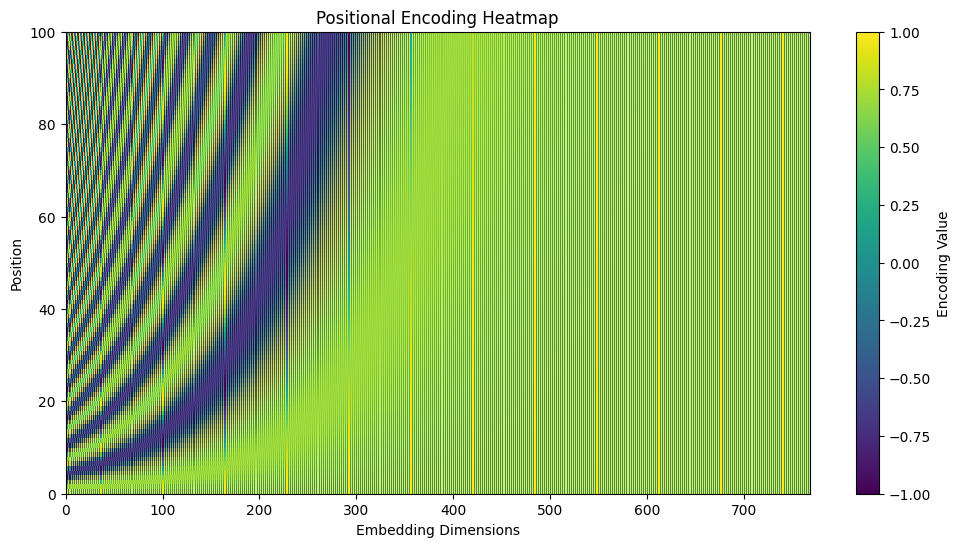

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def get_positional_encoding(seq_len, d_model):
    """
    Generate sinusoidal positional encodings.
    Args:
        seq_len (int): Length of the sequence.
        d_model (int): Dimension of the model.
    Returns:
        np.ndarray: Positional encoding matrix of shape (seq_len, d_model)
    """
    pos = np.arange(seq_len)[:, np.newaxis]            # (seq_len, 1)
    i = np.arange(d_model)[np.newaxis, :]              # (1, d_model)
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates                     # (seq_len, d_model)

    # apply sin to even indices; cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return angle_rads

# Parameters
seq_len = 100     # e.g., number of tokens
d_model = 768      # e.g., embedding dimension

# Generate positional encoding
pos_encoding = get_positional_encoding(seq_len, d_model)

# Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_encoding[:, :], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')
plt.colorbar(label='Encoding Value')
plt.show()


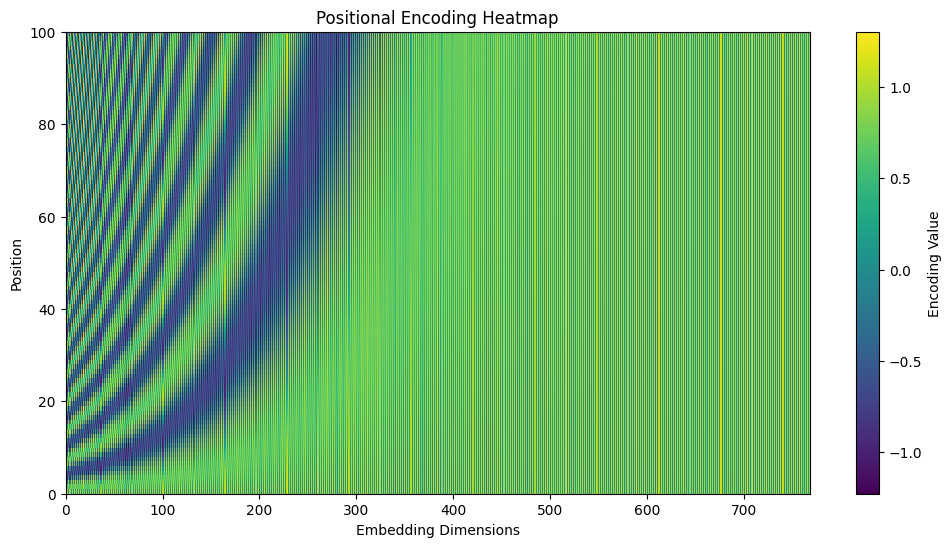

In [101]:
import torch
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
noise = torch.randn_like(input_tensor) * 0.1 # Adjust the scale of noise as needed
input_tensor = input_tensor + noise
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

# Access patch embedding layer (includes the linear projection)
patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise = patches - patch_embed(transform(image).unsqueeze(0)) 

noise[0][177]
# Extract the first patch for visualization

pos_encoding = get_positional_encoding(seq_len, d_model) + noise[0][100].detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_encoding[:, :], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')
plt.colorbar(label='Encoding Value')
plt.show()


In [102]:
import torch
import torch.nn as nn
import numpy as np
import torch.fft as fft

class FrequencyPixelAttacks(nn.Module):
    """
    A PyTorch transform to apply various frequency-based and pixel-based attacks.
    """
    def __init__(self, attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=None):
        super(FrequencyPixelAttacks, self).__init__()
        self.attack_type = attack_type
        self.epsilon = epsilon
        self.frequency_radius = frequency_radius
        self.num_pixels = num_pixels
        self.noise_std = noise_std
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def forward(self, img):
        perturbed_img = img.clone().detach()
        if self.attack_type == 'phase':
            perturbed_img = self._phase_attack(perturbed_img)
        elif self.attack_type == 'magnitude':
            perturbed_img = self._magnitude_attack(perturbed_img)
        elif self.attack_type == 'low_freq':
            perturbed_img = self._low_frequency_attack(perturbed_img)
        elif self.attack_type == 'high_freq':
            perturbed_img = self._high_frequency_attack(perturbed_img)
        elif self.attack_type == 'pixel':
            perturbed_img = self._pixel_attack(perturbed_img)
        elif self.attack_type == 'normal':
            perturbed_img = self._normal_noise_attack(perturbed_img)
        else:
            raise ValueError(f"Unknown attack type: {self.attack_type}")
        return torch.clamp(perturbed_img, 0, 1)
    
    def _phase_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            phase_noise = torch.randn_like(phase) * self.epsilon
            perturbed_phase = phase + phase_noise
            f_transform_perturbed = magnitude * torch.exp(1j * perturbed_phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _magnitude_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            magnitude_noise = torch.randn_like(magnitude) * self.epsilon * magnitude
            perturbed_magnitude = magnitude + magnitude_noise
            f_transform_perturbed = perturbed_magnitude * torch.exp(1j * phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _create_frequency_mask(self, height, width, is_low_freq=True):
        y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
        y_indices = y_indices - height // 2
        x_indices = x_indices - width // 2
        distance = torch.sqrt(y_indices**2 + x_indices**2).float()
        max_distance = torch.sqrt(torch.tensor(height**2 + width**2, dtype=torch.float32))
        distance /= max_distance
        return (distance <= self.frequency_radius).float() if is_low_freq else (distance >= (1 - self.frequency_radius)).float()
    
    def _low_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=True).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _high_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=False).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _pixel_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = img.clone()
        num_pixels = min(self.num_pixels, height * width)
        pixel_indices = torch.randint(0, height * width, (batch, num_pixels))
        y_indices, x_indices = pixel_indices // width, pixel_indices % width
        for b in range(batch):
            for c in range(channels):
                for i in range(num_pixels):
                    perturbed_img[b, c, y_indices[b, i], x_indices[b, i]] += torch.randn(1).item() * self.epsilon
        return perturbed_img
    
    def _normal_noise_attack(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise

def display_image(original, adversarial):
    """Display last batch of original and adversarial images."""
    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()
        
        orig_img = np.clip(orig_img, 0, 1)
        adv_img = np.clip(adv_img, 0, 1)

        
        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()

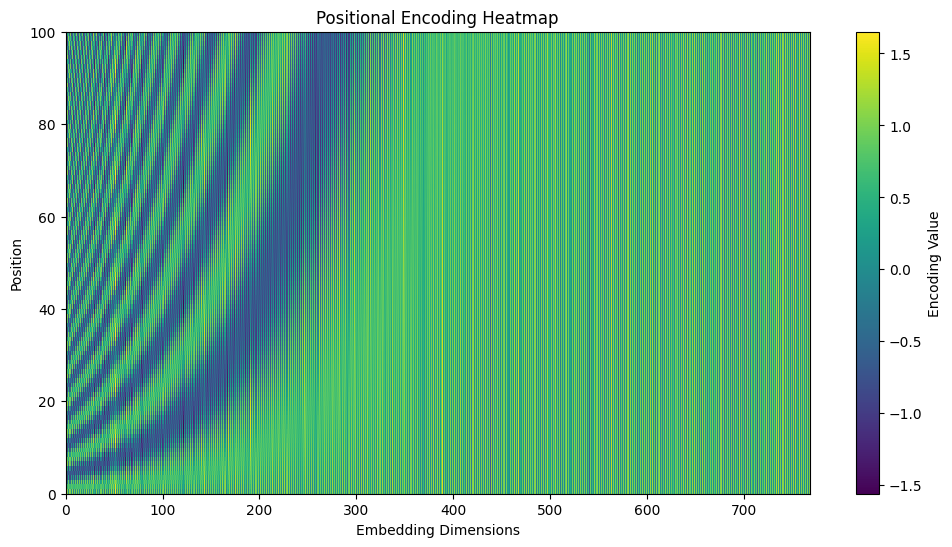

In [103]:
attacker = FrequencyPixelAttacks(
	attack_type='phase',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=10,
	seed=42
)

import torch
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

# Access patch embedding layer (includes the linear projection)
patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise = patches - patch_embed(transform(image).unsqueeze(0)) 
# Extract the first patch for visualization

pos_encoding = get_positional_encoding(seq_len, d_model) + noise[0][100].detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_encoding[:, :], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')
plt.colorbar(label='Encoding Value')
plt.show()


In [104]:
torch.argmax(torch.tensor([torch.linalg.norm(noise[0][i]) for i in range(196)]))

tensor(177)

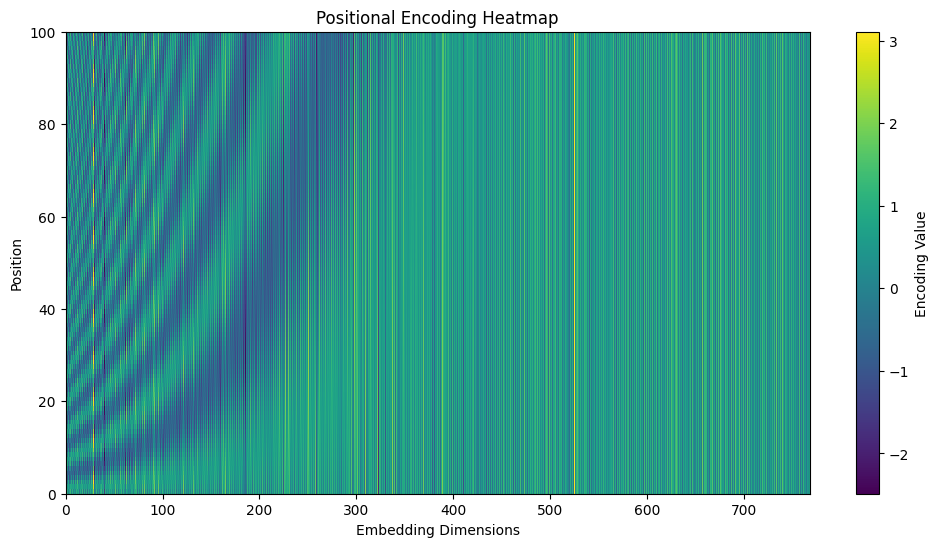

In [105]:
attacker = FrequencyPixelAttacks(
	attack_type='magnitude',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=0.05,
	seed=42
)

import torch
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

# Access patch embedding layer (includes the linear projection)
patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise = patches - patch_embed(transform(image).unsqueeze(0)) 

noise[0][1]
# Extract the first patch for visualization

pos_encoding = get_positional_encoding(seq_len, d_model) + noise[0][177].detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_encoding[:, :], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')
plt.colorbar(label='Encoding Value')
plt.show()


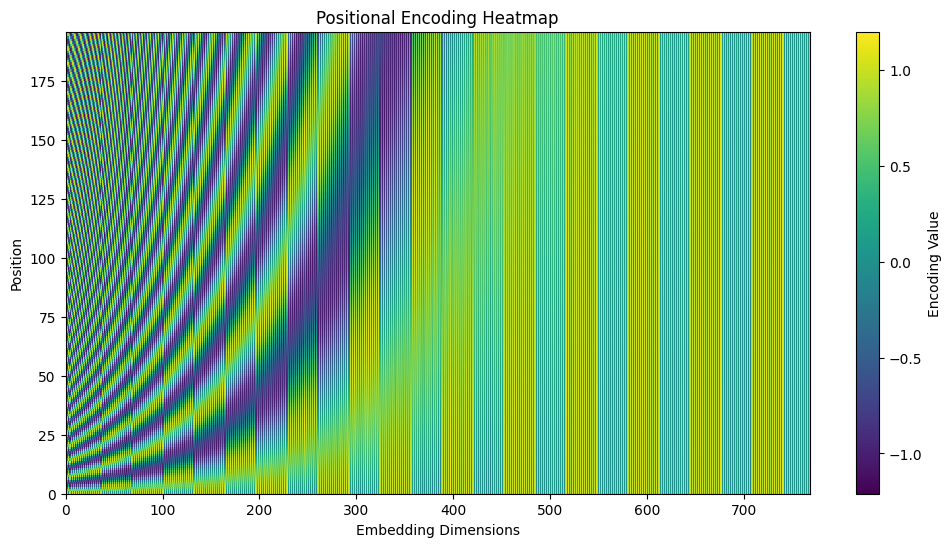

In [124]:
attacker = FrequencyPixelAttacks(
	attack_type='normal',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=0.05,
	seed=42
)

import torch
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

# Access patch embedding layer (includes the linear projection)
patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise = patches - patch_embed(transform(image).unsqueeze(0)) 
# Extract the first patch for visualization

pos_encoding = get_positional_encoding(seq_len, d_model) + noise[0][100].detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_encoding[:, :], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap')
plt.colorbar(label='Encoding Value')
plt.show()


In [120]:
print(noise_phase.shape)

torch.Size([1, 196, 768])


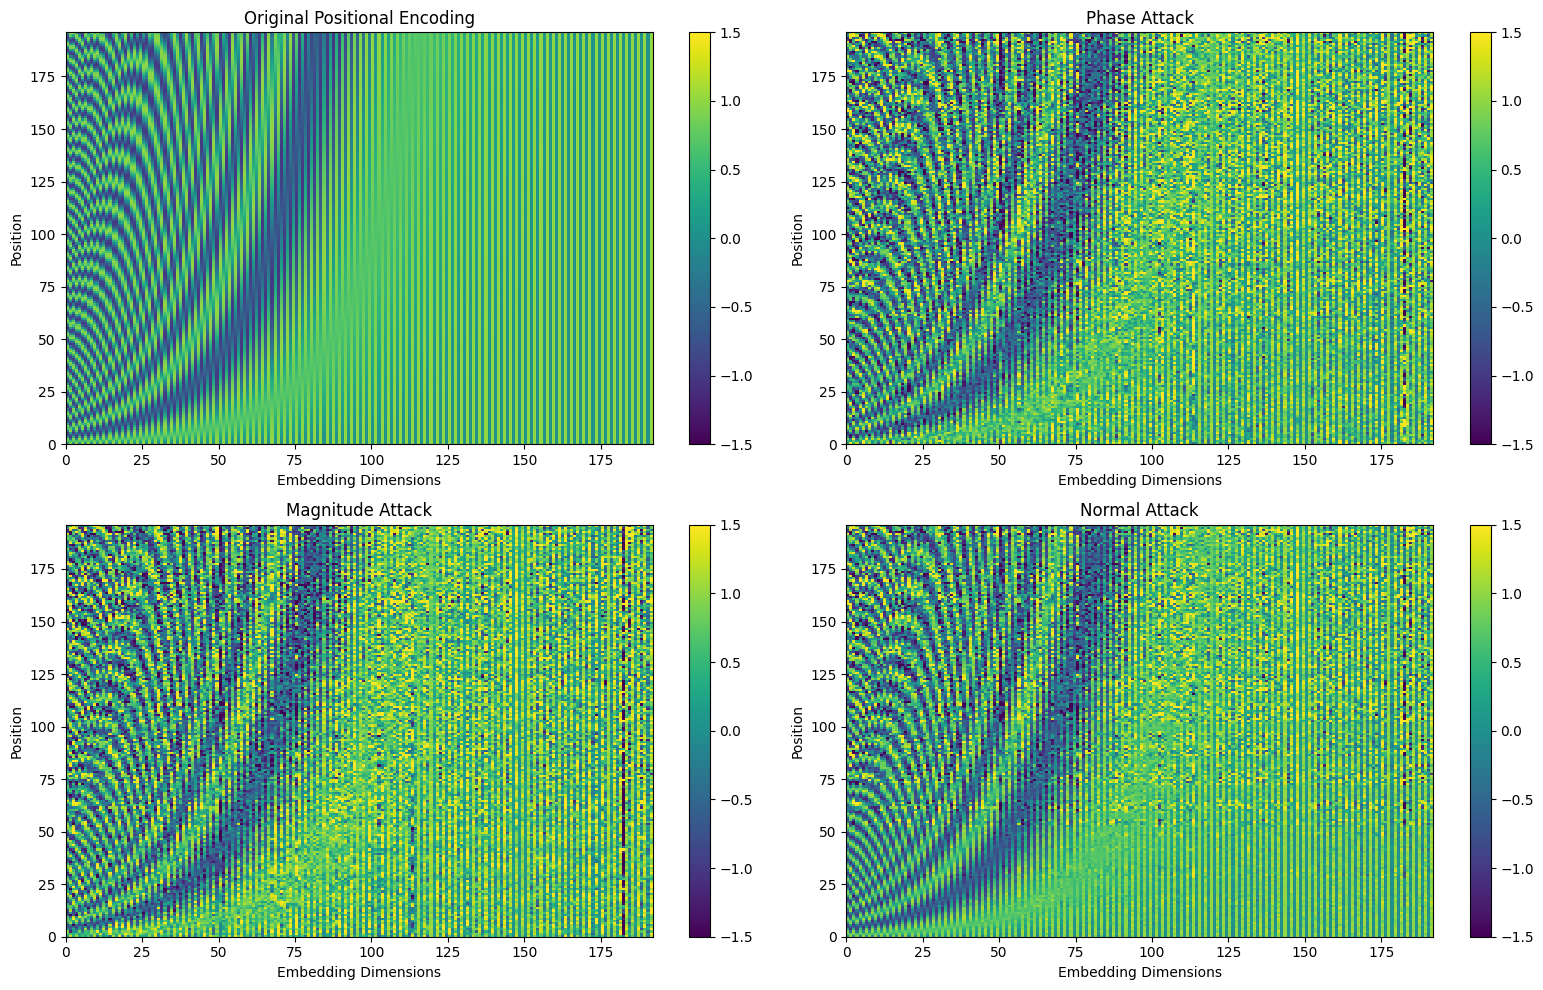

In [127]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
model.eval()

# Load and preprocess image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # (1, 3, 224, 224)

# If using adversarial attack or perturbation
# input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)

# Access patch embedding layer
patch_embed = model.patch_embed

# Get patch embeddings
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, 192)


import numpy as np
import matplotlib.pyplot as plt

def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return angle_rads

# Parameters
seq_len = 196
d_model = 192

# Original positional encoding
base_encoding = get_positional_encoding(seq_len, d_model)

# Example: assuming noise_phase, noise_magnitude, and noise_normal are precomputed from your code
# noise_phase = noise[0][100] # for phase attack
# noise_magnitude = noise[0][177] # for magnitude attack
# noise_normal = noise[0][100] # for normal attack

# Generate random noise for phase, magnitude, and normal attacks

attacker = FrequencyPixelAttacks(
	attack_type='phase',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=0.05,
	seed=42
)

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise_phase = patches - patch_embed(transform(image).unsqueeze(0))

attacker = FrequencyPixelAttacks(
	attack_type='magnitude',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=0.05,
	seed=42
)

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise_magnitude = patches - patch_embed(transform(image).unsqueeze(0))

attacker = FrequencyPixelAttacks(
	attack_type='normal',  # Choose from 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'
	epsilon=0.5,
	frequency_radius=0.1,
	num_pixels=100,
	noise_std=0.05,
	seed=42
)

# Load and preprocess an image
image_path = 'index-meta.jpeg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)
input_tensor = attacker(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # Ensure pixel values remain in valid range

patch_embed = model.patch_embed

# Get patches from image
with torch.no_grad():
    patches = patch_embed(input_tensor)  # Shape: (1, num_patches, embed_dim)

noise_normal = patches - patch_embed(transform(image).unsqueeze(0))

# Let's assume you have these from your runs:
# noise_phase, noise_magnitude, noise_normal

# Compose the 4 heatmaps
idx = 100
encodings = [
    (base_encoding, "Original Positional Encoding"),
    (base_encoding + noise_phase[0, :, :].detach().numpy(), "Phase Attack"),
    (base_encoding + noise_magnitude[0, :, :].detach().numpy(), "Magnitude Attack"),
    (base_encoding + noise_normal[0, :, :].detach().numpy(), "Normal Attack"),
]

# Plot all 4 in subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, (enc, title) in zip(axes, encodings):
    im = ax.pcolormesh(enc, cmap='viridis', vmin=-1.5, vmax=1.5)
    ax.set_title(title)
    ax.set_xlabel("Embedding Dimensions")
    ax.set_ylabel("Position")
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()


In [98]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# -------------------------
# Load pretrained ViT
# -------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval().to(device)

# Hook to extract positional embeddings
pos_embeddings = {}

def hook_pos_emb(module, input, output):
    pos_embeddings['pos'] = module.pos_embed.detach().cpu().numpy()

model.blocks[0].register_forward_hook(hook_pos_emb)  # Hook early block

# -------------------------
# Data + Transforms
# -------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# -------------------------
# Attack functions
# -------------------------

def fft_attack(image, eps=0.05):
    """Frequency-based perturbation (low-frequency emphasis)"""
    img_np = image.squeeze().cpu().numpy()
    img_np = np.fft.fft2(img_np, axes=(1, 2))
    mask = np.zeros_like(img_np)
    h, w = mask.shape[1:]
    mask[:, :h//8, :w//8] = 1  # low freq emphasis
    perturbed = img_np + eps * np.abs(img_np) * mask
    img_back = np.fft.ifft2(perturbed, axes=(1, 2)).real
    return torch.tensor(img_back).unsqueeze(0).to(image.device)

def spatial_noise(image, std=0.05):
    noise = torch.randn_like(image) * std
    return torch.clamp(image + noise, -1, 1)

# -------------------------
# Main Loop
# -------------------------
def run_and_extract(image):
    pos_embeddings.clear()
    with torch.no_grad():
        model(image)
    return pos_embeddings['pos'].squeeze()

original_embeddings = []
fft_embeddings = []
spatial_embeddings = []

for i, (img, _) in enumerate(loader):
    if i >= 10: break  # use 10 images for demo
    img = img.to(device)

    # Clean
    orig = run_and_extract(img)

    # Frequency attack
    fft_img = fft_attack(img)
    fft = run_and_extract(fft_img)

    # Spatial noise
    noisy_img = spatial_noise(img)
    spat = run_and_extract(noisy_img)

    original_embeddings.append(orig)
    fft_embeddings.append(fft)
    spatial_embeddings.append(spat)

# -------------------------
# Similarity Measures
# -------------------------

def compare_embeddings(orig, perturbed):
    cos_sims = []
    eucl_dists = []
    for o, p in zip(orig, perturbed):
        cos_sim = cosine_similarity(o.reshape(1, -1), p.reshape(1, -1))[0][0]
        eucl_dist = np.linalg.norm(o - p)
        cos_sims.append(cos_sim)
        eucl_dists.append(eucl_dist)
    return cos_sims, eucl_dists

fft_cos, fft_eucl = compare_embeddings(original_embeddings, fft_embeddings)
spat_cos, spat_eucl = compare_embeddings(original_embeddings, spatial_embeddings)

print("Avg Cosine Similarity (FFT attack):", np.mean(fft_cos))
print("Avg Cosine Similarity (Spatial noise):", np.mean(spat_cos))
print("Avg Euclidean Distance (FFT attack):", np.mean(fft_eucl))
print("Avg Euclidean Distance (Spatial noise):", np.mean(spat_eucl))

# -------------------------
# Optional: t-SNE Plot
# -------------------------
all_embeddings = original_embeddings + fft_embeddings + spatial_embeddings
labels = (['Clean'] * len(original_embeddings) +
          ['FFT'] * len(fft_embeddings) +
          ['Spatial'] * len(spatial_embeddings))

X = np.array([emb.flatten() for emb in all_embeddings])
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X)

colors = {'Clean': 'green', 'FFT': 'red', 'Spatial': 'blue'}

plt.figure(figsize=(8,6))
for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, c=colors[label], alpha=0.7)
plt.legend()
plt.title("t-SNE of Positional Embeddings")
plt.show()


AttributeError: 'Block' object has no attribute 'pos_embed'